In [1]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk

%aimport config 
sys.path.append(config.lib_dir)
%aimport utils
%aimport segment 
%aimport match 
%aimport register 
%aimport evaluate 
%aimport qc 
sys.path.append(config.script_dir)
from slide_registration import *

CPU times: user 1.12 s, sys: 1.12 s, total: 2.25 s
Wall time: 3.64 s


# Overview

The goal of this notebook is to compare the efficacy of the full slide's registrations for a given experiment.


In [2]:
# These must be adjusted to your specific experiment
unreg_path    = '/mnt/z/Marilyne/Axioscan/6-Dhivya/split/No_Scene/'
reg_path      = './registered_imgs/'
slide_name    = 'D3'
scene_name    = 'None'

In [3]:
img_file_names = [x for x in os.listdir(reg_path) if x[-4:] == '.tif']
parsed_names = pd.DataFrame([parse_file_name(x) for x in img_file_names])

# filter to slide/scene
parsed_names = parsed_names[lambda x: (x.slide_name == slide_name) & (x.scene == scene_name)]

# grab only the dapi channel 
parsed_names = parsed_names[lambda x: x.color_channel == 'c1']

parsed_names.head()

,round,protein,slide_name,date,scan_id,scene,color_channel,note,file_type,original
2,R1,H3K27ME3.AXL.CCND1.HER2,D3,2020-10-02,9179,None,c1,ORG,tif,R1_H3K27ME3.AXL.CCND1.HER2_D3_2020_10_02__9179...
18,R5,BCLxL.CD68.PD1.pATM,D3,2020-10-08,9275,None,c1,ORG,tif,R5_BCLxL.CD68.PD1.pATM_D3_2020_10_08__9275_c1_...
19,R7,Vimentin.BRCA1.CD8.CD44,D3,2020-10-12,9315,None,c1,ORG,tif,R7_Vimentin.BRCA1.CD8.CD44_D3_2020_10_12__9315...
21,R0,AF488.AF555.AF647.AF750,D3,2020-09-30,9158,None,c1,ORG,tif,R0_AF488.AF555.AF647.AF750_D3_2020_09_30__9158...
24,R6,pHH3.AR.Sting.CD45,D3,2020-10-09,9295,None,c1,ORG,tif,R6_pHH3.AR.Sting.CD45_D3_2020_10_09__9295_c1_O...


In [4]:
imgs_reg = utils.load_imgs_mt(parsed_names.original.values, reg_path)

starting multithreaded image loading...
assigning threads...done.
waiting for threads to complete.
finished task: 8/10
threads complete.

...image loading complete.


In [5]:
imgs_unreg = utils.load_imgs_mt(parsed_names.original.values, unreg_path)

starting multithreaded image loading...
assigning threads...done.
waiting for threads to complete.
finished task: 3/10
threads complete.

...image loading complete.


# Evaluating slide registration

In [18]:
np.array(list(imgs_reg.keys()))[[('R0' in x and 'c1' in x) for x in imgs_reg.keys()]][0]

array(['R0_AF488.AF555.AF647.AF750_D3_2020_09_30__9158_c1_ORG.tif'],
      dtype='<U59')

KeyError: 'R0_AF488.AF555.AF647.AF750_D1_2020_09_30__9123_c1_ORG.tif'

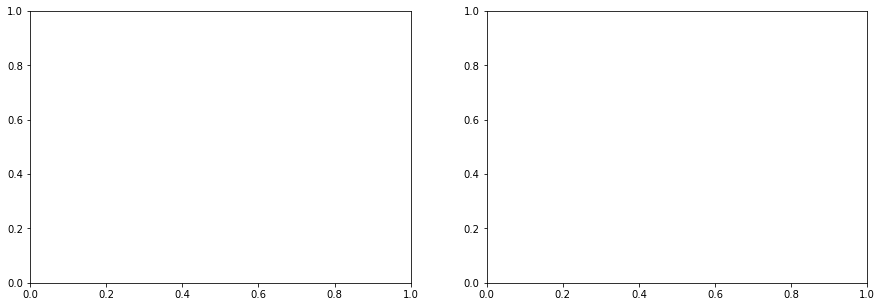

In [6]:
f,axes = plt.subplots(1,2, figsize=(15,5))

R0_name = np.array(list(imgs_reg.keys()))[[('R0' in x and 'c1' in x) for x in imgs_reg.keys()]][0]
fixed = imgs_reg['R0_AF488.AF555.AF647.AF750_D1_2020_09_30__9123_c1_ORG.tif']

utils.myshow(fixed[::10, ::10], ax=axes.flat[0], title='raw')
seg_fixed = fixed_blur > np.quantile(sitk.GetArrayFromImage(fixed_blur), 0.75)
utils.myshow(seg_fixed[::10, ::10], ax=axes.flat[1], title='segmented')
plt.suptitle('fixed slide')

plt.show()

In [ ]:
def plot_reg(moving, seg_fixed, ax, title): 
    
    #moving  = gaussian.Execute ( moving )
    #seg_fixed = fixed > np.quantile(fixed, 0.75)
    #seg_fixed = sitk.Cast(fixed, sitk.sitkInt8)
    seg_moving = moving > np.quantile(sitk.GetArrayFromImage(moving), 0.75)
    seg_moving = sitk.Cast(seg_moving, sitk.sitkInt8)
    seg_fixed = sitk.Cast(seg_fixed, sitk.sitkInt8)
    
    sub = seg_fixed - seg_moving
    utils.myshow(sub[::10, ::10], ax=ax, title=title)

im_names = list(imgs_reg.keys())
im_names.sort()
for _im in im_names: 
    #print(_im)
    moving_reg = imgs_reg[_im]
    moving_unreg = imgs_unreg[_im]
    
    moving_unreg = sitk.Resample(moving_unreg, seg_fixed)
    moving_reg = sitk.Resample(moving_reg, seg_fixed)
    
    f, axes = plt.subplots(1,2, figsize=(15,5))
    plot_reg(moving_reg, seg_fixed, axes.flat[0], 'registered')
    
    plot_reg(moving_unreg, seg_fixed, axes.flat[1], 'unregistered')
    plt.suptitle(_im)
    plt.show()